In [93]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from intvalpy import lineqs


from src import functions
from src import trainer
from src import models
from src import utils

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

In [94]:
# Random seeds
training_seed = 42
test_seed = 78

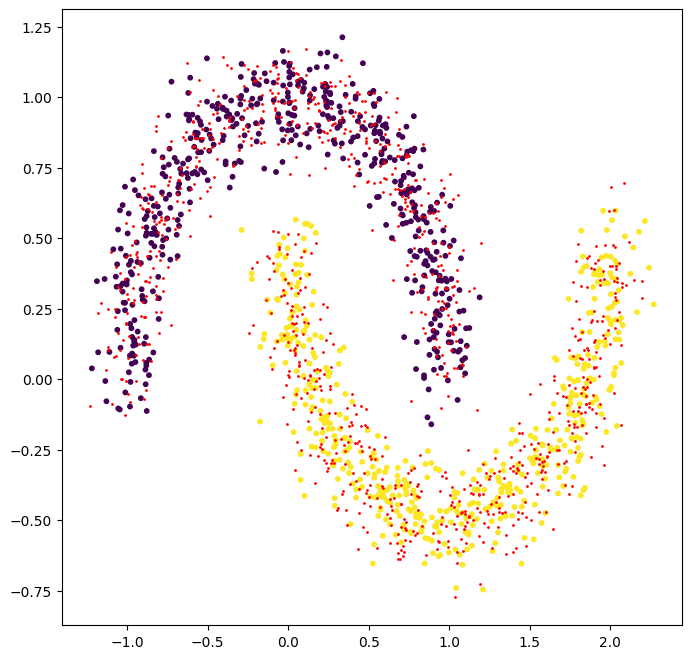

In [95]:
# Data to generate regions
X_train, y_train = make_moons(n_samples=1000, noise=0.1, random_state=training_seed)
# Convert to torch tensors
X_train, y_train = to_tensor(X_train), to_tensor(y_train)

# Generate test data with random data
X_test, y_test = make_moons(n_samples=1000, noise=0.1, random_state=test_seed)
X_test, y_test = to_tensor(X_test), to_tensor(y_test)

# Visualize data
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=10)
ax.scatter(X_test[:,0], X_test[:,1], c="r", s=1)

In [96]:
# Data points from which to sample the regions
bound_scale_factor = 1.1
boundsx1 = [to_np(X_train[:,0].min()*bound_scale_factor), to_np(X_train[:,0].max()*bound_scale_factor)]
boundsx2 = [to_np(X_train[:,1].min()*bound_scale_factor), to_np(X_train[:,1].max()*bound_scale_factor)]
print(boundsx1, boundsx2)

n = 5
x_1 = np.linspace(boundsx1[0], boundsx1[1], n, dtype="float32")
x_2 = np.linspace(boundsx2[0], boundsx2[1], n, dtype="float32")
x_1, x_2 = np.meshgrid(x_1, x_2)
x_1 = np.reshape(x_1, (n**2,1))
x_2 = np.reshape(x_2, (n**2,1))
x_sample = np.concatenate((x_1,x_2), axis = 1)
print(x_sample.shape)

[array(-1.34111, dtype=float32), array(2.49802, dtype=float32)] [array(-0.8204, dtype=float32), array(1.33348, dtype=float32)]
(25, 2)


Text(0, 0.5, '$x_2$')

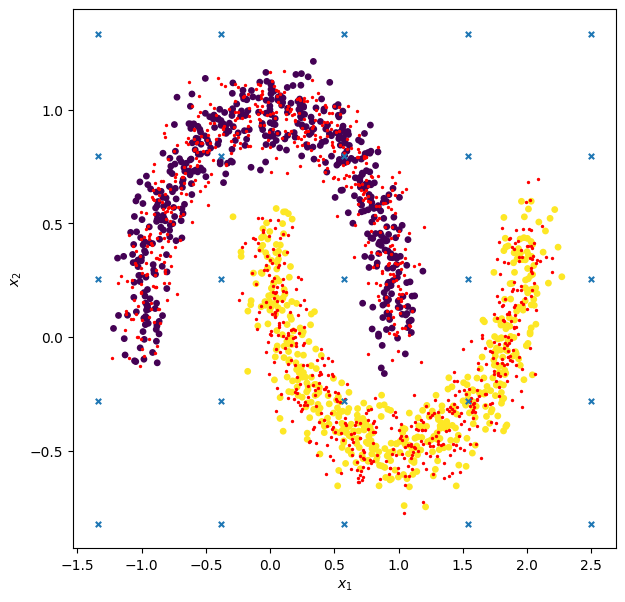

In [152]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=15)
ax.scatter(X_test[:,0], X_test[:,1], c="r", s=2)
ax.scatter(x_sample[:,0], x_sample[:,1], marker="x",s=15)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [98]:
# Model 
model = utils.NeuralNet(input_size = 2, num_classes = 1, hidden_sizes=[3,3,3,3,3,3])
model.train()
# Training params
EPOCHS = 15000
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.1)
# optimizer = torch.optim.Adam(model.parameters())
LOAD = False
save_everyth_epoch = 500
SAVE_STATES = False

In [99]:

# train_loss, train_accuracy = [], []
# test_loss, test_accuracy = [], []
# for epoch in trange(EPOCHS):
#     model.train()
#     optimizer.zero_grad()
    
#     out = model(X_train)
#     loss = criterion(out, y_train.unsqueeze(1))
#     loss.backward()
#     train_loss.append(loss.item())
#     optimizer.step()
#     optimizer.zero_grad()
#     preds = torch.sigmoid(out) > 0.5
#     accuracy = (preds.squeeze() == y_train).float().mean().item()
#     train_accuracy.append(accuracy)
    
#     model.eval()
#     with torch.no_grad():
#         out = model(X_test)
#         loss = criterion(out, y_test.unsqueeze(1))
#         preds = torch.sigmoid(out) > 0.5
#         accuracy = (preds.squeeze() == y_test).float().mean().item()
#         test_loss.append(loss.item())
#         test_accuracy.append(accuracy)
#     if SAVE_STATES and (epoch % save_everyth_epoch == 0 or epoch == EPOCHS-1):
#         torch.save(model.state_dict(), f'state_dicts/epoch{epoch}.pth')
    
# SAVE_STATES=False

In [100]:
train_loss = np.load('state_dicts/train_loss.npy')
test_loss = np.load('state_dicts/test_loss.npy')
train_accuracy = np.load('state_dicts/train_accuracy.npy')
test_accuracy = np.load('state_dicts/test_accuracy.npy')


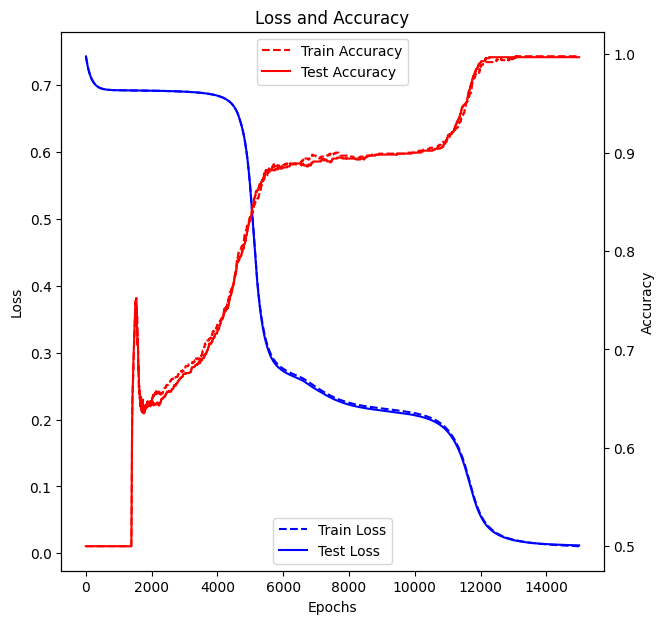

In [149]:
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.plot(train_loss, label='Train Loss', ls='--', c='blue')
ax1.plot(test_loss, label='Test Loss', ls='-', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss and Accuracy')
ax1.legend(loc="lower center")

ax2 = ax1.twinx()
ax2.plot(train_accuracy, label='Train Accuracy', ls='--', c='red')
ax2.plot(test_accuracy, label='Test Accuracy', ls='-', c='red')
ax2.set_ylabel('Accuracy')
ax2.legend(loc="upper center")
plt.show()

In [102]:
# def save_array(_list, _path):
#     np.save(_path, np.asarray(_list))
    
    
# save_array(train_loss, 'state_dicts/train_loss.npy')
# save_array(test_loss, 'state_dicts/test_loss.npy')
# save_array(train_accuracy, 'state_dicts/train_accuracy.npy')
# save_array(test_accuracy, 'state_dicts/test_accuracy.npy')


In [103]:
# # Try to load a pre-trained model
# if LOAD:
#     try:
#         model.load_state_dict(torch.load('experiment_model.pth'))
#         print("Model loaded successfully.")
#         losses = np.load("experiment_losses.npy")
#     except FileNotFoundError:
#         print("Model file not found. Training a new model.")
#         losses = []
#         for epoch in trange(EPOCHS):
#             model.train()
#             optimizer.zero_grad()
            
#             out = model(X_train)
#             loss = criterion(out, y_train.unsqueeze(1))
#             loss.backward()
#             losses.append(loss.item())
#             optimizer.step()
#             optimizer.zero_grad()
            
#         torch.save(model.state_dict(), 'experiment_model.pth')
#         np.save('experiment_losses.npy', np.array(losses))
#         print("Model trained and saved successfully.")
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.plot(losses, label='Loss')
#         ax.set_xlabel('Epochs')
#         ax.set_ylabel('Loss')
#         ax.set_title('Training Loss')
#         ax.legend()
#         plt.show()
# else:
#     losses = []
#     for epoch in trange(EPOCHS):
#         model.train()
#         optimizer.zero_grad()
        
#         out = model(X_train)
#         loss = criterion(out, y_train.unsqueeze(1))
#         loss.backward()
#         losses.append(loss.item())
#         optimizer.step()
#         optimizer.zero_grad()
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.plot(losses, label='Loss')
#     ax.set_xlabel('Epochs')
#     ax.set_ylabel('Loss')
#     ax.set_title('Training Loss')
#     ax.legend()
#     plt.show()
    

In [104]:
# Function to load a state dict
def load_from_state_dict(model, epoch):
    model.load_state_dict(torch.load(f'state_dicts/epoch{epoch}.pth'))
    model.eval()

In [105]:
# load_from_state_dict(model, 8000)

In [106]:
# Accuracy for training set
# model.eval()
# success = 0.5
# with torch.no_grad():
#     out = model(X_train)
#     preds = torch.sigmoid(out) > success
#     accuracy = (preds.squeeze() == y_train).float().mean().item()
#     print(f"Training Accuracy: {accuracy:.4f}")
    


# with torch.no_grad():
#     out = model(to_tensor(X_test))
#     preds = torch.sigmoid(out) > success
#     accuracy = (preds.squeeze() == to_tensor(y_test)).float().mean().item()
#     print(f"Training Accuracy: {accuracy:.4f}")

In [107]:
# # Random point(s) to sample regions from
# random_sample = to_np(X_train[88,:].unsqueeze(-1))  # Example: first point in the training set
# print(f"Random sample point:\n{random_sample}\nshape: {random_sample.shape}")

In [108]:
def regions_for_sample_point(model, random_sample, bound = 2.5):
    # print(f"Random sample point:\n{random_sample}\nshape: {random_sample.shape}")
    
    A_random_sample, c_random_sample, [random_sample_bit_vector_list] = functions.get_inequalities(model,random_sample,return_bit_vec_list=True, input_dimension=2 )
        
    indexes_for_active_bits_random_sample, stats = functions.active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )
    
    polytope_list, active_bit_count_list  = functions.get_polytope_list(random_sample_bit_vector_list, indexes_for_active_bits_random_sample, input_dimension=2, model=model)
    
    bit_string_list_from_alg = polytope_list

    def divide_column_vector(column_vector):
        return np.array_split(column_vector, 6)

    list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]
    
    A_alg, c_alg = functions.get_inequalities(model,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2)
    # print(f"Length of A_alg: {len(A_alg)}")
    
    verticles_list_alg = []


    def find_verticles(A, c, bound):
        # Find the boundaries of the polytope defined by Ax <= c
        for A, c in zip (A_alg, c_alg):
            verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
            verticles_list_alg.append(verticles)
        # return verticles_list_alg
    errors = 0
    
    try:
        find_verticles(A_alg, c_alg,bound)
    except IndexError:
        errors += 1
    # print(f"Encountered {errors} errors")
    
    # bound = 3

    # fig = plt.figure()
    # ax = fig.add_subplot(111, aspect='equal')
    # patches = []
    # num_polygons = len(verticles_list_alg)
    # colors = [np.random.randint(1, 300) for i in range(num_polygons)]
    # cmap = matplotlib.colormaps['rainbow']

    polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


    # # for i in range(num_polygons):
    # for i in range(num_polygons):
    #     vertices_i = verticles_list_alg[i]
        
    #     # Check if any vertex falls within the boundaries
    #     vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
    # #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    #     if vertices_within_boundaries:
    #         polygon = Polygon(xy=vertices_i,
    #                         closed=True,
    #                         facecolor=cmap(colors[i]),
    #                         edgecolor='black',
    #                         #   label=np.transpose(bit_string_list_from_alg[i])[0],
    #                         )
    #         ax.add_patch(polygon)
        
    #         patches.append(polygon)
            
    #         polytopes_within_boundaries += 1

            
            

    # ax.set_xlim([-bound, bound])
    # ax.set_ylim([-bound, bound])
    # # Show random sample point
    # ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

    # p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
    # # np.random.seed(10)
    # colors = [np.random.randint(1, 1000) for i in range(len(patches))]
    # plt.show()

    # print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")
    return verticles_list_alg


In [109]:
# point = x_sample[0].reshape(-1,1)
# point.shape

In [110]:
# list_of_lists_of_vertices_training_data = regions_for_sample_point(X_train)
# regions_array = regions_for_sample_point(model, point)


In [111]:
# from tqdm import tqdm
# list_of_lists_of_vertices_training_data = []
# list_of_lists_of_vertices_sample_data = []

# training_data_subset = to_np(X_train)[::75]

# # for point in x_sample:
# for point in tqdm(training_data_subset, desc="Training data"):
#     local_list = regions_for_sample_point(point.reshape(-1,1))
#     list_of_lists_of_vertices_training_data.append(local_list)
# for point in tqdm(x_sample, desc="Sample data"):
#     local_list = regions_for_sample_point(point.reshape(-1,1))
#     list_of_lists_of_vertices_sample_data.append(local_list)


In [112]:
# function to find regions for an array of points
# from tqdm import tqdm
def find_all_regions_for_points(model, points=x_sample):
    list_of_lists_of_vertices = []
    for point in points:
        local_list = regions_for_sample_point(model, point.reshape(-1,1))
        list_of_lists_of_vertices.append(local_list)
    return list_of_lists_of_vertices

In [113]:
# regions_of_point = find_all_regions_for_points(model)

In [114]:
# from itertools import zip_longest
# list_of_lists_of_vertices[6]

# vertices = np.vstack([v_array for v_array in list_of_lists_of_vertices])

# arr_filled = [list(tpl) for tpl in zip(*zip_longest(*list_of_lists_of_vertices))]
# vertices = np.vstack([v_array for v_array in arr_filled])
# vertices = np.asarray(arr_filled, dtype="object")


In [115]:
# Function to get unique polygons from list of lists of vertices
def get_unique_polygons(list_of_lists_of_vertices):
    list_of_vertices = []
    for list_of_local_vertices in list_of_lists_of_vertices:
        for local_vertices in list_of_local_vertices:
            list_of_vertices.append(local_vertices)
    vertices_as_tuples = [tuple(map(tuple, vertex)) for vertex in list_of_vertices]
    unique_vertices = set(vertices_as_tuples)
    unique_vertices_as_arrays = [np.array(vertex) for vertex in unique_vertices]
    return unique_vertices_as_arrays

    

In [116]:
# unique_polygons = get_unique_polygons(regions_of_point)

In [161]:
def plot_vertices(unique_vertices, epoch=None, show=True):
    bound = 2.5

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(aspect='equal')
    patches = []
    num_polygons = len(unique_vertices)
    colors = [np.random.randint(1, 300) for i in range(num_polygons)]
    cmap = matplotlib.colormaps['rainbow']

    polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


    # for i in range(num_polygons):
    for i in range(num_polygons):
        vertices_i = unique_vertices[i]
        
        # Check if any vertex falls within the boundaries
        vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
    #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
        if vertices_within_boundaries:
            polygon = Polygon(xy=vertices_i,
                            closed=True,
                            facecolor=cmap(colors[i]),
                            edgecolor='black',
                            #   label=np.transpose(bit_string_list_from_alg[i])[0],
                            )
            ax.add_patch(polygon)
        
            patches.append(polygon)
            
            polytopes_within_boundaries += 1

            
            

    ax.set_xlim([-bound, bound])
    ax.set_ylim([-bound, bound])
    # Show random sample point
    # ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

    p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
    # np.random.seed(10)
    colors = [np.random.randint(1, 1000) for i in range(len(patches))]
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=15)
    # ax.scatter(x_sample[:,0], x_sample[:,1], s=1)
    ax.set_title(f"Epoch: {epoch}")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    if show:
        plt.show()
    return ax

In [154]:
# Function to find and plot regions for a given epoch
def find_regions(model, epoch=0, show_plot=True):
    # Load the correct state dict of the model:
    load_from_state_dict(model, epoch)
    # Find all the regions
    regions_of_points = find_all_regions_for_points(model)
    # Get all the unique regions
    unique_polygons = get_unique_polygons(regions_of_points)
    
    if show_plot:
        plot_vertices(unique_polygons, epoch)
    return unique_polygons
    

In [119]:
# plot_vertices(unique_polygons)

In [120]:
# find_regions(model, epoch=0, show_plot=True)
# find_regions(model, epoch=5000, show_plot=True)
# find_regions(model, epoch=12000, show_plot=True)
# find_regions(model, epoch=14999, show_plot=True)


In [121]:
epochs = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 14999]

In [122]:
# Create the dictionaries

# dict_of_polytopes = {}
# for epoch in epochs:
    # print(f'Calculating for epoch {epoch}')
    # polytopes = find_regions(model, epoch=epoch, show_plot=True)
    # dict_of_polytopes[f'epoch{epoch}'] = polytopes
    
# Load dictionary

    

In [123]:
import pickle


# with open('saved_dictionary.pkl', 'wb') as f:
#     pickle.dump(dictionary, f)
        
# with open('saved_dictionary.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)


# with open('polytope_dict.pkl', 'wb') as f:
#     pickle.dump(dict_of_polytopes, f)
    
with open('polytope_dict.pkl', 'rb') as f:
    dict_of_polytopes = pickle.load(f)

In [155]:
def plot_epoch(epoch, show=True):
    plot_vertices(dict_of_polytopes[f'epoch{epoch}'], epoch=epoch, show=show)

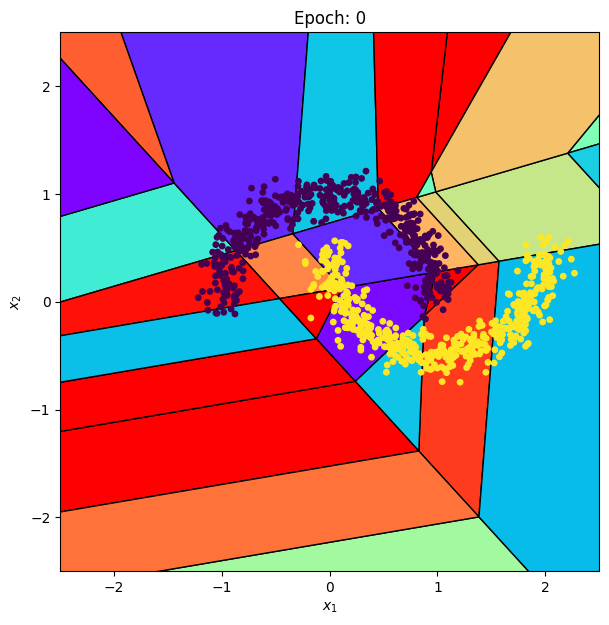

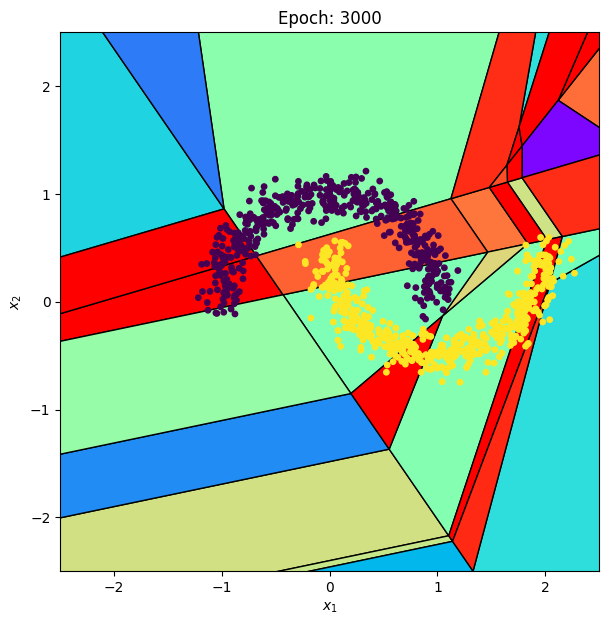

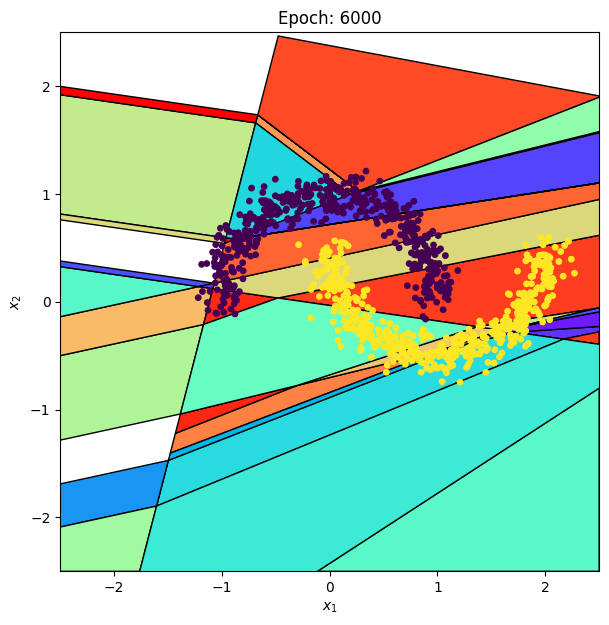

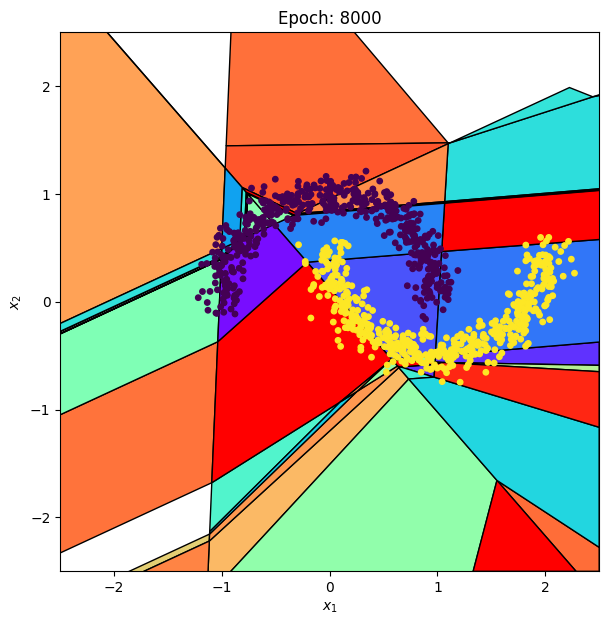

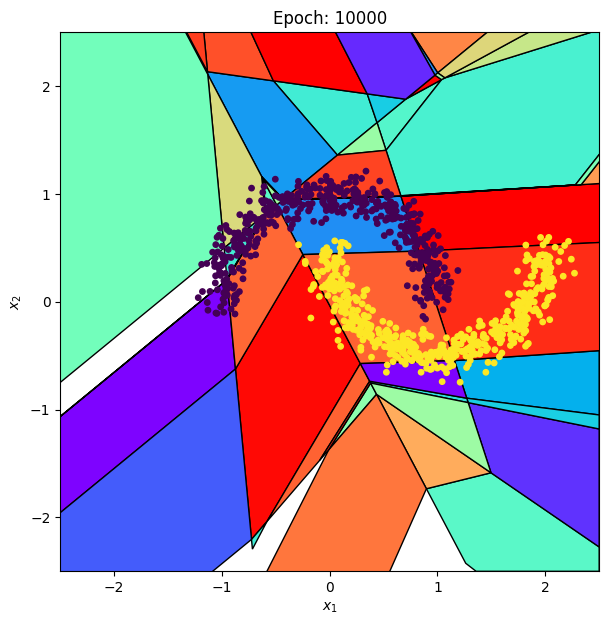

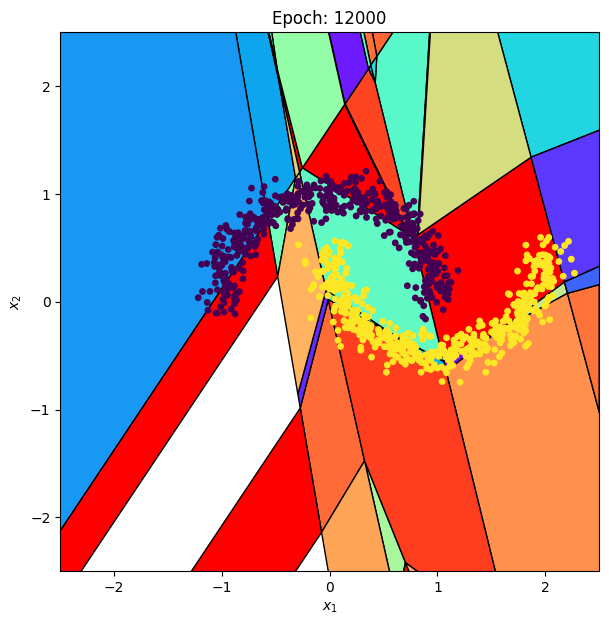

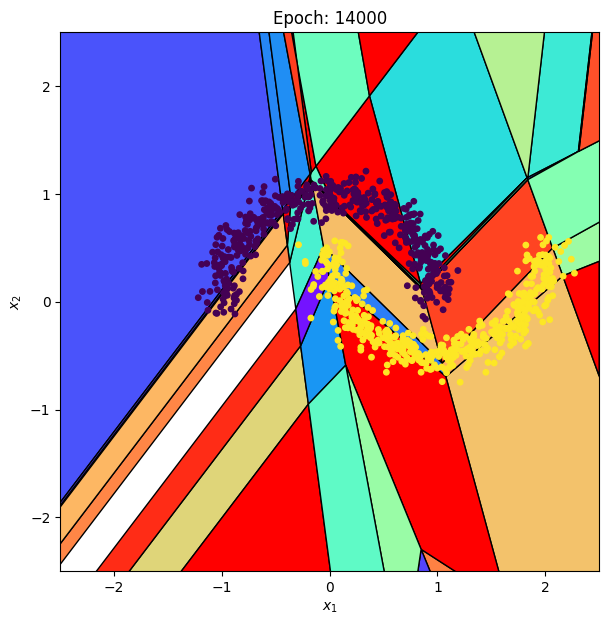

In [164]:
for epoch in [0,3000, 6000, 8000, 10000, 12000, 14000]:
    plot_epoch(epoch)

In [ ]:
# dict_of_polytopes[f'epoch{0}'][43].shape[0]

In [ ]:
# class CustomPolygon:
#     def __init__(self, vertices):
#         self.vertices = vertices 
#         self.nr_vertices = vertices.shape[0]
#         self.dimension = self.vertices[1]
        

In [128]:
import polytope as pc

# test_vertices = dict_of_polytopes[f'epoch{0}'][0]
# hull = pc.qhull(test_vertices)

In [ ]:
# print(test_vertices)

In [ ]:
# print(hull.vertices)

In [129]:
def plot_hull(hull, ax=None):
    bound = 2.5



    polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


    # for i in range(num_polygons):

    vertices_i = hull.vertices
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
#     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        print(f'Volume: {hull.volume}')
        fig = plt.figure(figsize=(12,10))
        if ax is None:
            ax = fig.add_subplot(223, aspect='equal')
        else:
            ax = ax
        polygon = Polygon(xy=vertices_i,
                        closed=True,
                        facecolor='black',
                        edgecolor='black',
                        #   label=np.transpose(bit_string_list_from_alg[i])[0],
                        )
        ax.add_patch(polygon)
        ax.set_xlim([-bound, bound])
        ax.set_ylim([-bound, bound])

        p = PatchCollection([polygon], cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
        ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=2.5)
        plt.show()
        
        
        polytopes_within_boundaries += 1

    else:
        print('Outside bounds')
        print(f'Volume: {hull.volume}')
        return
            
        

In [165]:
# for i in range(len(dict_of_polytopes[f'epoch{0}'])):
#     print(f'Region nr: {i+1}')
#     hull = pc.qhull(dict_of_polytopes[f'epoch{0}'][i])
#     ax = plot_epoch(0, show=False)
#     plot_hull(hull, ax=ax)

In [ ]:
# list_of_vertices = []
# list_of_vertices_sample = []
# for list_of_local_vertices in list_of_lists_of_vertices_training_data:
#     for local_vertices in list_of_local_vertices:
#         list_of_vertices.append(local_vertices)
        
# for list_of_local_vertices in list_of_lists_of_vertices_sample_data:
#     for local_vertices in list_of_local_vertices:
#         list_of_vertices_sample.append(local_vertices)

In [ ]:
# vertices_as_tuples = [tuple(map(tuple, vertex)) for vertex in list_of_vertices]
# vertices_as_tuples_sample = [tuple(map(tuple, vertex)) for vertex in list_of_vertices_sample]


In [ ]:
# len(vertices_as_tuples)

In [ ]:
# unique_vertices = set(vertices_as_tuples)
# unique_vertices_sample = set(vertices_as_tuples_sample)


In [ ]:
# len(unique_vertices)

In [ ]:
# overlaps = [vertex for vertex in vertices_as_tuples if vertices_as_tuples.count(vertex) > 1]

In [ ]:
# print(len(overlaps))

In [ ]:
# unique_vertices_as_arrays = [np.array(vertex) for vertex in unique_vertices]
# unique_vertices_as_arrays_sample = [np.array(vertex) for vertex in unique_vertices_sample]


In [ ]:
# unique_vertices_as_arrays

In [ ]:
# from collections import Counter

# Counter(map(tuple,list_of_vertices))

In [ ]:
# bound = 2.5

# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(223, aspect='equal')
# patches = []
# num_polygons = len(unique_vertices_as_arrays)
# colors = [np.random.randint(1, 300) for i in range(num_polygons)]
# cmap = matplotlib.colormaps['rainbow']

# polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


# # for i in range(num_polygons):
# for i in range(num_polygons):
#     vertices_i = unique_vertices_as_arrays[i]
    
#     # Check if any vertex falls within the boundaries
#     vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
# #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
#     if vertices_within_boundaries:
#         polygon = Polygon(xy=vertices_i,
#                         closed=True,
#                         facecolor=cmap(colors[i]),
#                         edgecolor='black',
#                         #   label=np.transpose(bit_string_list_from_alg[i])[0],
#                         )
#         ax.add_patch(polygon)
    
#         patches.append(polygon)
        
#         polytopes_within_boundaries += 1

        
        

# ax.set_xlim([-bound, bound])
# ax.set_ylim([-bound, bound])
# # Show random sample point
# # ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

# p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# # np.random.seed(10)
# colors = [np.random.randint(1, 1000) for i in range(len(patches))]
# ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=2.5)
# # ax.scatter(x_sample[:,0], x_sample[:,1], s=1)
# ax.set_title("From training data")

# ax = fig.add_subplot(224, aspect='equal')
# patches = []
# num_polygons = len(unique_vertices_as_arrays_sample)
# colors = [np.random.randint(1, 300) for i in range(num_polygons)]
# cmap = matplotlib.colormaps['rainbow']

# polytopes_within_boundaries_sample = 0  # Counter for polytopes within boundaries


# # for i in range(num_polygons):
# for i in range(num_polygons):
#     vertices_i = unique_vertices_as_arrays_sample[i]
    
#     # Check if any vertex falls within the boundaries
#     vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
# #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
#     if vertices_within_boundaries:
#         polygon = Polygon(xy=vertices_i,
#                         closed=True,
#                         facecolor=cmap(colors[i]),
#                         edgecolor='black',
#                         #   label=np.transpose(bit_string_list_from_alg[i])[0],
#                         )
#         ax.add_patch(polygon)
    
#         patches.append(polygon)
        
#         polytopes_within_boundaries_sample += 1

        
        

# ax.set_xlim([-bound, bound])
# ax.set_ylim([-bound, bound])
# # Show random sample point
# # ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

# p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# # np.random.seed(10)
# colors = [np.random.randint(1, 1000) for i in range(len(patches))]
# ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=2.5)
# ax.scatter(x_sample[:,0], x_sample[:,1], s=1)
# ax.set_title("From sample data")

# ax2 = fig.add_subplot(211)
# # losses = np.load("experiment_losses.npy")
# ax2.set_title("Loss")
# ax2.set_xlabel("Epochs")
# ax2.plot(losses)
# plt.show()

# print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")
# print(f"The number of polytopes within the boundaries (sample) is: {polytopes_within_boundaries_sample}")


\begin{align}
    \hat{I}(X;Y) &= \sum_k\sum_{k'}p_{kk'}\log{\left( \frac{p_{kk'}}{p_kp_{k'}} \right)} = \sum_k\sum_{k'} \frac{n_{kk'}}{|\mathcal{D}_X||\mathcal{D}_Y|\mathcal{V}^X_k\mathcal{V}^Y_{k'}}\log{\left( \frac{\frac{n_{kk'}}{|\mathcal{D}_X||\mathcal{D}_Y|\mathcal{V}^X_k\mathcal{V}^Y_{k'}}}{\frac{n^X_k}{|\mathcal{D}_X|\mathcal{V}^X_k}\frac{n^Y_{k'}}{|\mathcal{D}_Y|\mathcal{V}^Y_{k'}}}  \right)} \nonumber \\
    &= \frac{1}{|\mathcal{D}_X||\mathcal{D}_Y|}\sum_k\sum_{k'} \frac{n_{kk'}}{\mathcal{V}^X_k\mathcal{V}^Y_{k'}}\log{\frac{n_{kk'}}{n^X_kn^Y_{k'}}}.
\end{align}

In [ ]:
from shapely.geometry import Point as shpoint
from shapely.geometry.polygon import Polygon as shpolygon

Dx = X_train
Dx.shape[0]

1000